In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
import sys

import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

sys.path.append('..')
from attribute_control import EmbeddingDelta
from attribute_control.model import SDXL
from attribute_control.prompt_utils import get_mask, get_mask_regex

torch.set_float32_matmul_precision('high')

DEVICE = 'cuda:0'
DTYPE = torch.bfloat16

/home/cuichen/anaconda3/envs/env_cc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = SDXL(
    pipeline_type='diffusers.StableDiffusionXLPipeline',
    model_name='stabilityai/stable-diffusion-xl-base-1.0',
    pipe_kwargs={ 'torch_dtype': DTYPE },
    device=DEVICE
)

Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='hf-mirror.com', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-xl-base-1.0 (Caused by ProxyError('Unable to connect to proxy', NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6483d97ac0>: Failed to establish a new connection: [Errno 110] Connection timed out')))"), '(Request ID: 5f830399-e6f0-4473-9ab9-4f2994f218b4)').
Will try to load from local cache.
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


In [12]:
delta = EmbeddingDelta(model.dims)
state_dict = torch.load('../pretrained_deltas/person_age.pt')
# state_dict = torch.load('../outputs/learn_delta/people/age/runs/2024-12-06/14-25-43/checkpoints/delta.pt')
# state_dict = torch.load('../outputs/learn_delta/people/age/runs/2025-01-07/07-35-18/checkpoints/delta.pt')
delta.load_state_dict(state_dict['delta'])
delta = delta.to(DEVICE)

/tmp/ipykernel_231639/3498463512.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('../pretrained_deltas/person_age.pt')


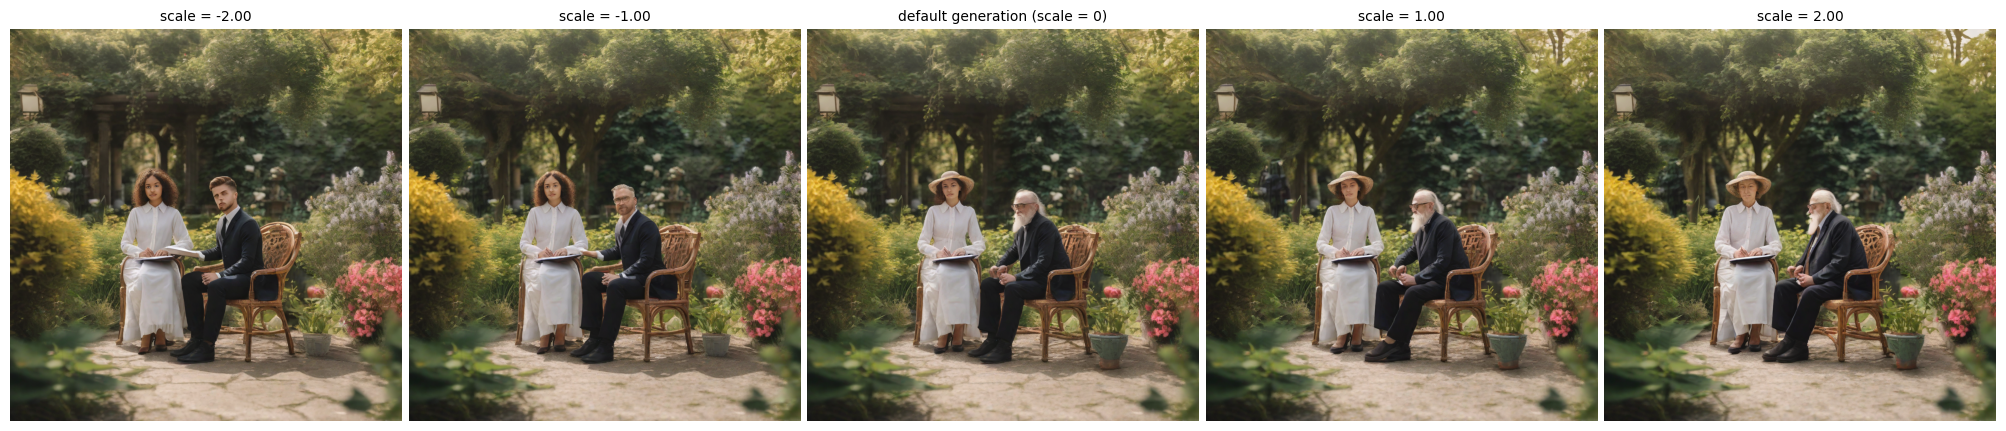

In [14]:
prompt = 'a photo of a write man sitting in a chair and a write woman standing next to him in a beautiful garden'
#prompt1 : a photo of a beautiful man
#prompt2 : a photo of a write man sitting in a chair and a write woman standing next to him in a beautiful garden

# The delta is applied to this regex pattern in the positive prompt
# If you don't feel comfortable with regex, use get_mask(prompt, target) instead
pattern_target = r'\b(man)\b'
prompt_negative = None # Optional negative prompt
seed = 42
scales = np.linspace(-2, 2, num=5) # [0.0, 1.0]

# Delta application delay
# Set to 0 to apply the delta for the whole sampling process
# Set to something between 0 and 1 to skip applying the delta for the first steps (e.g., first 20% of steps for 0.2)
# If you prefer a minor change to the overall image (e. g., just the face changing when modifying age), set to ~0.2
# If you'd rather want major changes that capture all correlations such as the background changing with age, set to 0.0
delay_relative = 0.20

# Sample from the set of provided scales
characterwise_mask = get_mask_regex(prompt, pattern_target)
emb = model.embed_prompt(prompt)
emb_neg = None if prompt_negative is None else model.embed_prompt(prompt_negative)
imgs = []
for alpha in scales:
    img = model.sample_delayed(
        # Multiple deltas can simply be applied by stacking delta.apply() calls with different deltas
        embs=[delta.apply(emb, characterwise_mask, alpha)],
        embs_unmodified=[emb],
        embs_neg=[emb_neg],
        delay_relative=delay_relative,
        generator=torch.manual_seed(seed),
        guidance_scale=7.5
    )[0]
    imgs.append(img)

    # Display outputs
    # clear_output()
    # plt.figure(figsize=(16, 14))
    # # for i, (alpha, img) in enumerate(zip(scales, imgs, strict=False)):
    # for i, (alpha, img) in enumerate(zip(scales, imgs)):
    #     # plt.subplot(1, len(imgs), i + 1)
    #     plt.subplot(4, 5, i + 1)
    #     plt.imshow(img)
    #     plt.title(f'scale = {alpha:.2f}' if alpha != 0 else 'default generation (scale = 0)', fontsize=10)
    #     plt.axis('off')
    # plt.tight_layout(pad=0.5, h_pad=1.0, w_pad=0.5)
    # plt.subplots_adjust(top=0.9)
    # plt.show()
    clear_output()
    plt.figure(figsize=(max(10, 4 * len(imgs)), 5))
    for i, (alpha, img) in enumerate(zip(scales, imgs)):
        plt.subplot(1, len(imgs), i + 1)
        plt.imshow(img)
        plt.title(f'scale = {alpha:.2f}' if alpha != 0 else 'default generation (scale = 0)', fontsize=10)
        plt.axis('off')
    plt.tight_layout(pad=0.5, h_pad=1.0, w_pad=0.5)
    plt.subplots_adjust(top=0.9)
    plt.show()